# Pipeline for High-z Radio Galaxies 10: SHAP values for base models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the base-learners used for predictions.  
It is possible to select either a random sample from the predicted pipeline (non-star, radio AGN) or high-redshift sources,  
regardless of their predicted values.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
from sklearn.model_selection import train_test_split
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

---

In [3]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = True
run_high_z_flag     = False  # If True, run on original high-z sources. False for running on random set of predicted non-star, rAGN.
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies)

### Load data

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [4]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Test_Train'  # Validation, Training, Test, Test_Train

In [5]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [6]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [7]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [8]:
full_catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6729647 entries, 0 to 6729646
Data columns (total 93 columns):
 #   Column        Dtype  
---  ------        -----  
 0   RA_ICRS       float32
 1   DE_ICRS       float32
 2   Name          object 
 3   TYPE          object 
 4   Z             float32
 5   zsp           float32
 6   spCl          object 
 7   band_num      int64  
 8   num_imputed   int64  
 9   radio_detect  bool   
 10  is_str        int64  
 11  is_SDSS_QSO   int64  
 12  is_AGN        int64  
 13  is_SDSS_gal   int64  
 14  is_gal        int64  
 15  W1mproPM      float32
 16  W2mproPM      float32
 17  gmag          float32
 18  rmag          float32
 19  imag          float32
 20  zmag          float32
 21  ymag          float32
 22  Jmag          float32
 23  Hmag          float32
 24  Kmag          float32
 25  W3mag         float32
 26  W4mag         float32
 27  g_r           float32
 28  g_i           float32
 29  g_z           float32
 30  g_y           floa

Create features with class and combined redshift.

In [9]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [10]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

In [11]:
if used_area == 'HETDEX':
    if use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
            (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
    elif not use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                        random_state=gv.seed, stratify=full_catalog_df.loc[:, 'class'])
    train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                        random_state=gv.seed, stratify=train_test_df.loc[:, 'class'])
    print('Shape of used data in HETDEX')
    print('(Confirmed galaxies and AGN)')
    print('-' * 50)
    print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
    print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
    print(f'Training data:                      {train_df.shape}')
    print(f'Testing data:                       {test_df.shape}')
    print(f'Unseen Data For Validation:         {validation_df.shape}')
    print('-' * 50)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Test_Train': train_test_df,\
                        'Validation': validation_df}
    full_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
(Confirmed galaxies and AGN)
--------------------------------------------------
Full confirmed dataset size:        (83409, 95)
Data for Modeling (Train and Test): (66727, 95)
Training data:                      (46708, 95)
Testing data:                       (20019, 95)
Unseen Data For Validation:         (16682, 95)
--------------------------------------------------

Using Test_Train data from HETDEX


In [12]:
if used_area != 'HETDEX':
    filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                       (full_catalog_df.loc[:, 'class'] == 1) |\
                       (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
    full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [13]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [14]:
if use_unknown:
    full_catalog_df = unknown_cat_df

In [15]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (66727, 91)
--------------------------------------------------
Thus, it has 66,727 sources and 91 features.


### Load models

In [16]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [17]:
if use_zeroth_model:
    threshold_star_logit = np.log(gv.star_thresh / (1 - gv.star_thresh))
threshold_AGN_logit      = np.log(gv.AGN_thresh / (1 - gv.AGN_thresh))
threshold_radio_logit    = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

Predictions

In [18]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=gv.star_thresh, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

Obtain intermediate predictions from base models. They are log-odds, must be converted to probs.

In [19]:
# aaa = AGN_gal_clf.named_steps['trained_model'].transform(full_catalog_df.loc[:,
#                                                                              get_final_column_names(AGN_gal_clf,
#                                                                                                     full_catalog_df)].copy())

In [20]:
# aaa_df = pd.DataFrame(aaa)
# (np.exp(aaa_df.loc[:, [20, 21, 22, 23]]) / (1 + np.exp(aaa_df.loc[:, [20, 21, 22, 23]]))).describe()

In [21]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [22]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [23]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=6)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [24]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [25]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on sub-set of base learners.

In [26]:
run_shap_AGN_base    = True
run_shap_radio_base  = True
run_shap_z_base      = True
run_shap_high_z_base = True

#### Select relevant sources

In this case, high-redshift sources

In [27]:
if run_high_z_flag:
    filter_selection = np.array(full_catalog_df.loc[:, 'Z'] >= gv.high_z_limit) &\
                       np.array(full_catalog_df.loc[:, 'class'] == 1) &\
                       np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
elif not run_high_z_flag:
    filter_selection = np.ones_like(full_catalog_df.loc[:, 'Z']).astype(bool)

In [28]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [29]:
if run_shap_AGN_base:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [30]:
if run_shap_AGN_base:
    sample_size_AGN  = 1000
    sub_size_AGN     = np.nanmin([sample_size_AGN, np.sum(filter_selection * filter_pred_no_str)])
    print(f'Number of selected elements: {sub_size_AGN:,}')

Number of selected elements: 1,000


In [31]:
if run_shap_AGN_base:
    base_models_names_AGN = gf.get_base_estimators_names(AGN_gal_clf)

In [32]:
if run_shap_AGN_base:
    reduced_data_AGN    = full_catalog_df.loc[filter_selection].sample(n=sub_size_AGN, random_state=gv.seed).copy()
    reduced_data_AGN_df = gf.preprocess_data(AGN_gal_clf, reduced_data_AGN, base_models_names_AGN)
    reduced_cols_AGN    = reduced_data_AGN_df.columns.drop(base_models_names_AGN)

Use FastTreeSHAP package

In [33]:
if run_shap_AGN_base:
    explainers_AGN_base = {}
    for model, model_fit in zip(AGN_gal_clf.named_steps['trained_model'].estimators, AGN_gal_clf.named_steps['trained_model'].estimators_):
        explainers_AGN_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',
                                                                   model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)  # No data

In [34]:
if run_shap_AGN_base:
    shap_values_AGN_base  = {}
    for model in explainers_AGN_base.keys():
        print(f'Working with base model {model}')
        shap_values_AGN_base[model] = explainers_AGN_base[model](reduced_data_AGN_df.drop(columns=base_models_names_AGN), check_additivity=False)

Working with base model xgboost
Working with base model et
Working with base model gbc
Working with base model rf


In [35]:
if run_shap_AGN_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_AGN_base.keys():
        print(f'{model: <10}\t: {np.array([explainers_AGN_base[model].expected_value]).flatten()[-1]: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	: -1.1827
et        	:  0.3387
gbc       	: -1.3731
rf        	:  0.3385


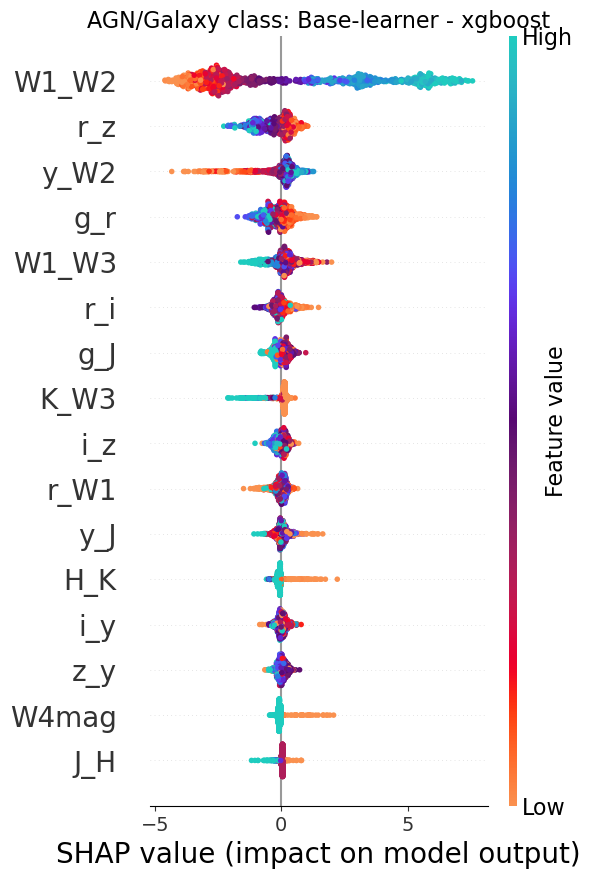

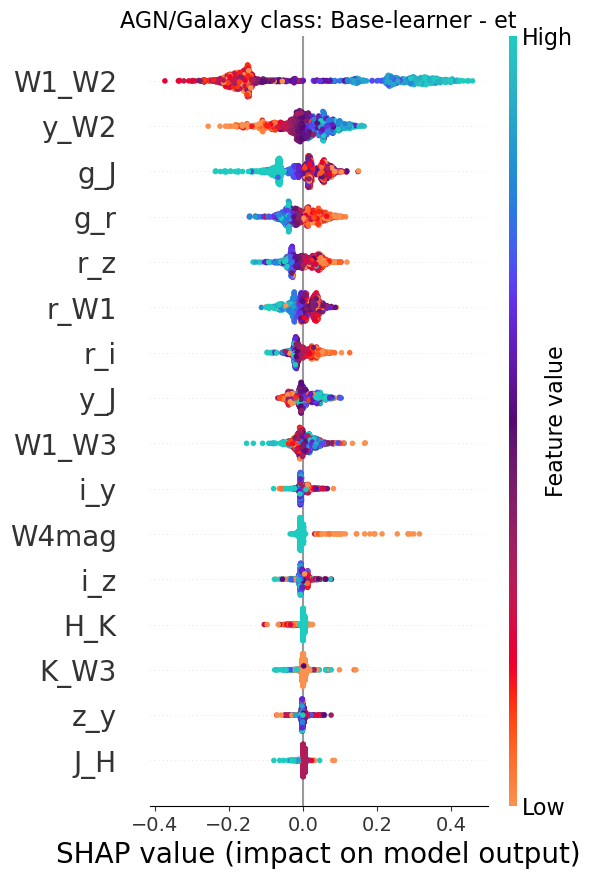

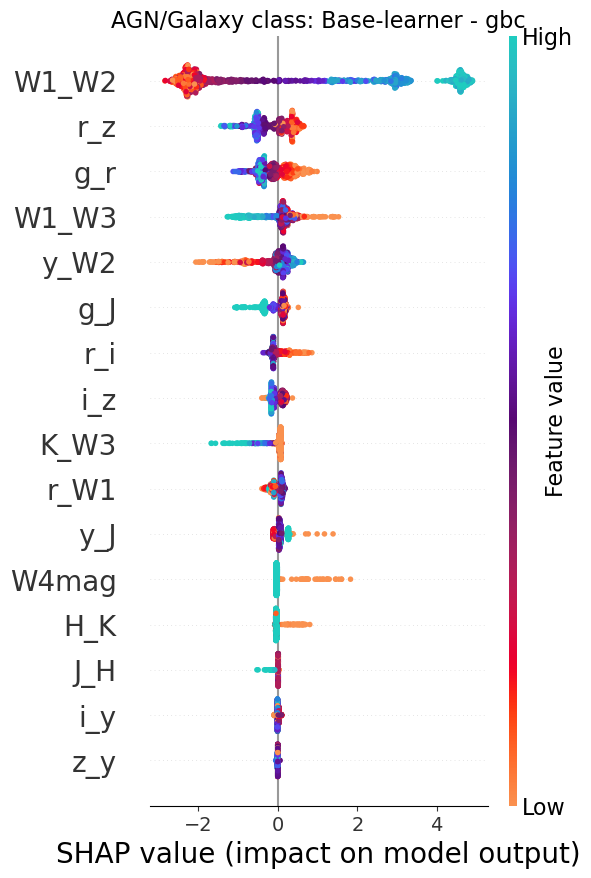

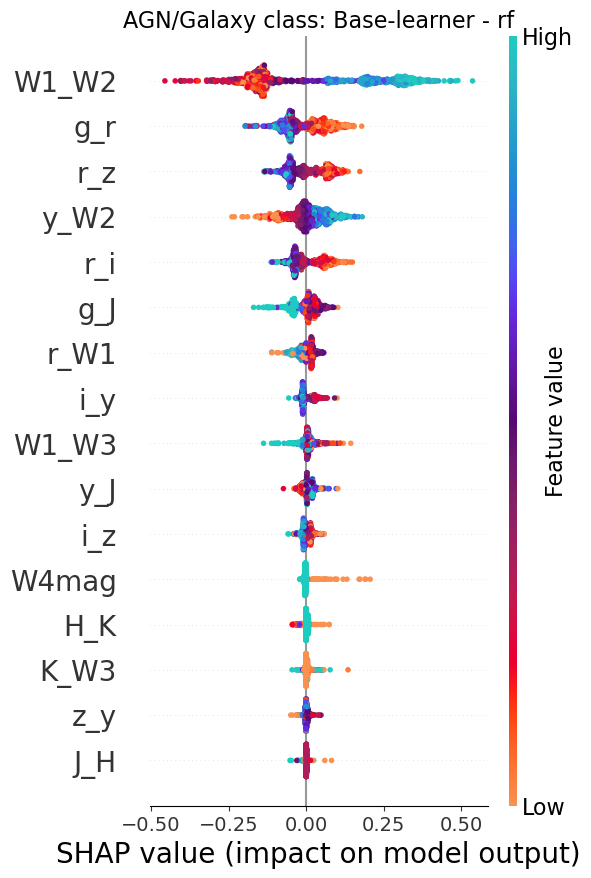

In [36]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        gf.plot_shap_beeswarm('AGN/Galaxy class', model, shap_values_AGN_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_AGN_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

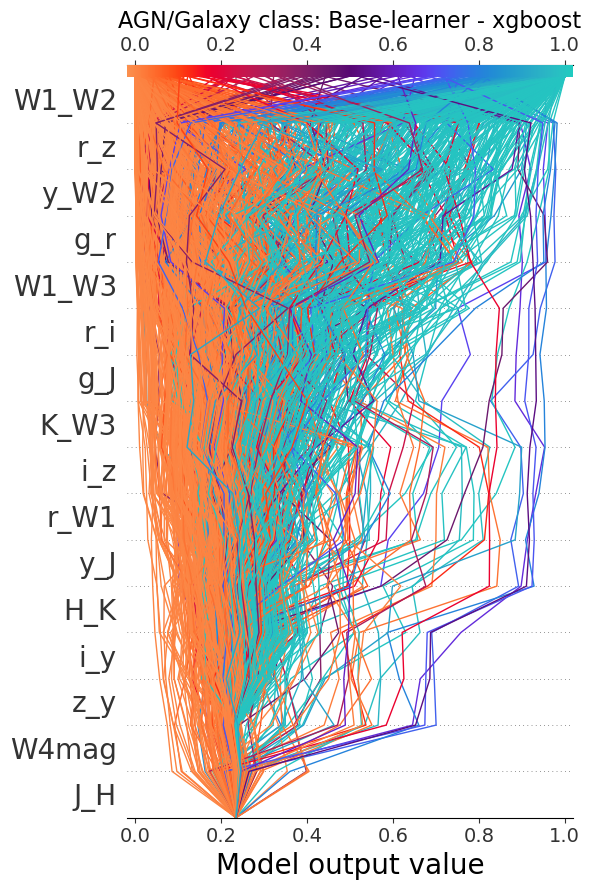

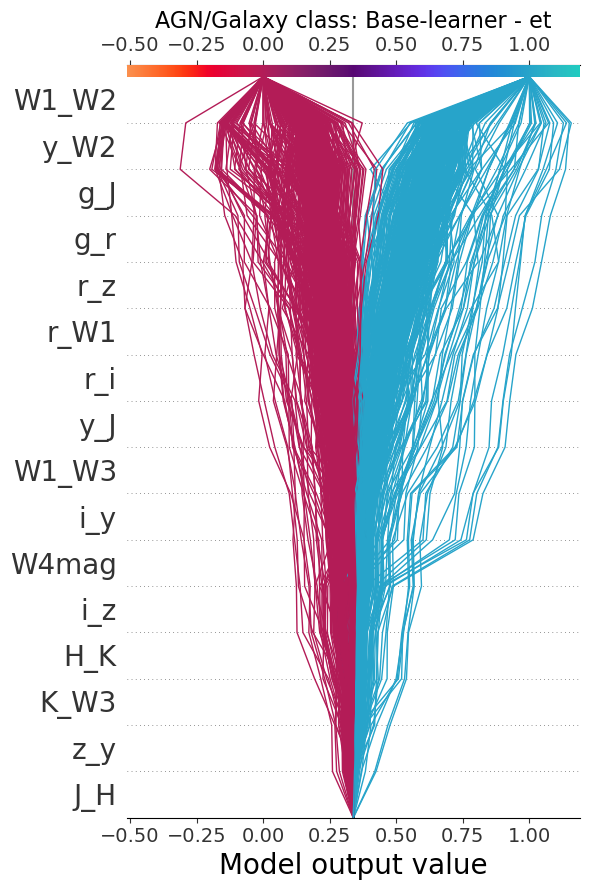

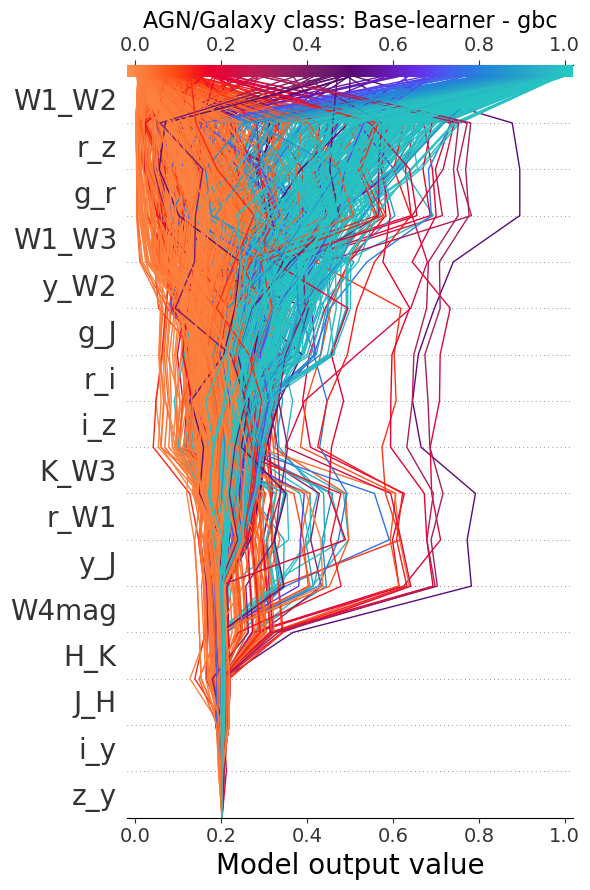

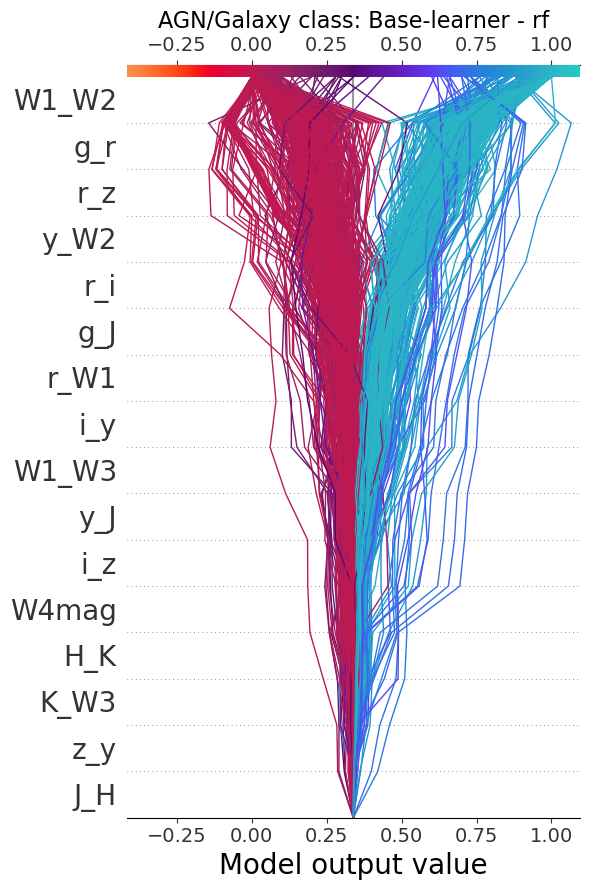

In [37]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        size_side       = 6
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode = 'logit'
        else:
            logit_mode = 'identity'
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('AGN/Galaxy class', model, shap_values_AGN_base[model], explainers_AGN_base[model],\
                           reduced_cols_AGN, ax1, logit_mode, new_base_value=None, base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_AGN_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [38]:
if run_shap_AGN_base:
    for count, model in enumerate(shap_values_AGN_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(AGN_gal_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_AGN_df.drop(columns=base_models_names_AGN))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_AGN_base[model].expected_value]).flatten()[-1] + shap_values_AGN_base[model].values[0].sum()).round(5))


xgboost:
0
-7.24946

et:
0
0.33871

gbc:
0
-3.78084

rf:
0
0.33853


---

#### SHAP - Radio detection model

In [39]:
if run_shap_radio_base:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [40]:
if run_shap_radio_base:
    sample_size_radio   = 1000
    if run_high_z_flag:
        filter_pred_AGN = np.ones_like(full_catalog_df.loc[:, 'pred_class']).astype(bool)
    elif not run_high_z_flag:
        filter_pred_AGN = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    sample_size_radio   = np.nanmin([sample_size_radio, np.sum(filter_selection * filter_pred_AGN)])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 1,000


In [41]:
if run_shap_radio_base:
    base_models_name_radio   = gf.get_base_estimators_names(radio_det_clf)

In [42]:
if run_shap_radio_base:
    reduced_data_radio    = full_catalog_df.loc[filter_selection].sample(n=sample_size_radio, random_state=gv.seed).copy()
    reduced_data_radio_df = gf.preprocess_data(radio_det_clf, reduced_data_radio, base_models_name_radio)
    reduced_cols_radio    = reduced_data_radio_df.columns.drop(base_models_name_radio)

Use FastTreeSHAP package

In [43]:
if run_shap_radio_base:
    explainers_radio_base           = {}
    for model, model_fit in zip(radio_det_clf.named_steps['trained_model'].estimators, radio_det_clf.named_steps['trained_model'].estimators_):
        explainers_radio_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                     model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [44]:
if run_shap_radio_base:
    shap_values_radio_base = {}
    for model in explainers_radio_base.keys():
        print(f'Working with base model {model}')
        shap_values_radio_base[model] = explainers_radio_base[model](reduced_data_radio_df.drop(columns=base_models_name_radio))

Working with base model rf
Working with base model xgboost
Working with base model et
Working with base model gbc


In [45]:
if run_shap_radio_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_radio_base.keys():
        print(f'{model: <10}\t: {np.array([explainers_radio_base[model].expected_value]).flatten()[-1]: .4f}')

Expected "logit" values per base model
------------------------------
rf        	:  0.3048
xgboost   	: -0.9680
et        	:  0.3043
gbc       	: -1.0131


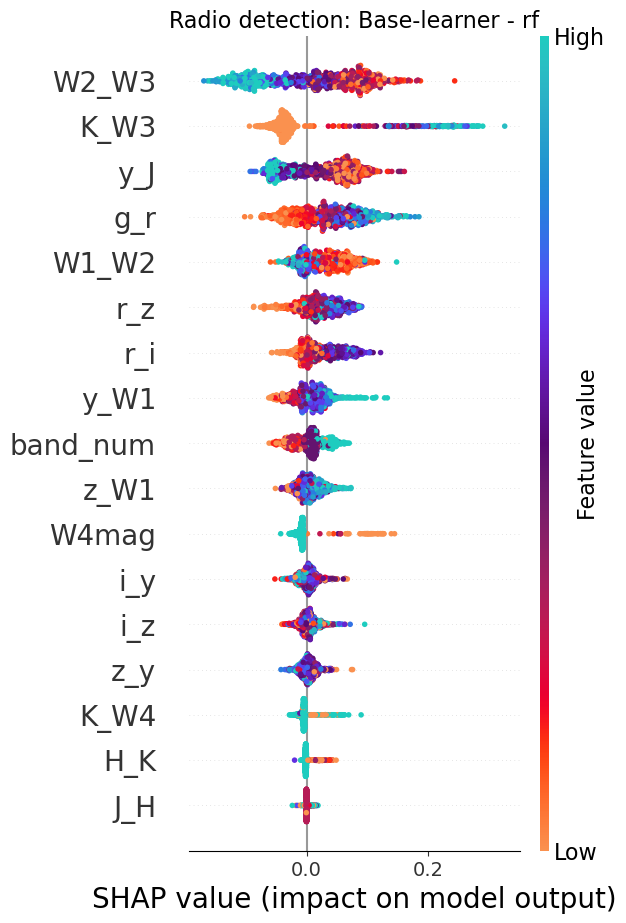

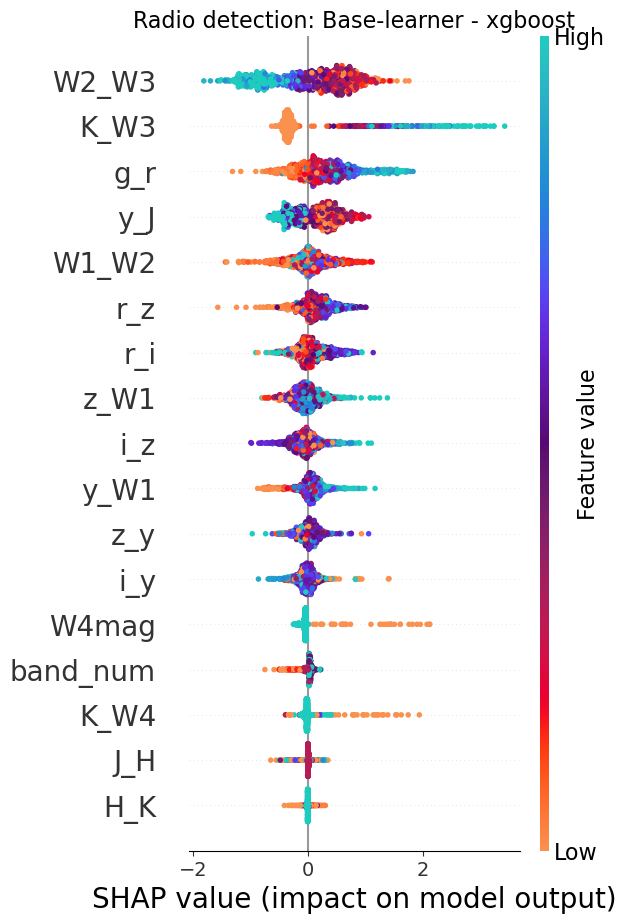

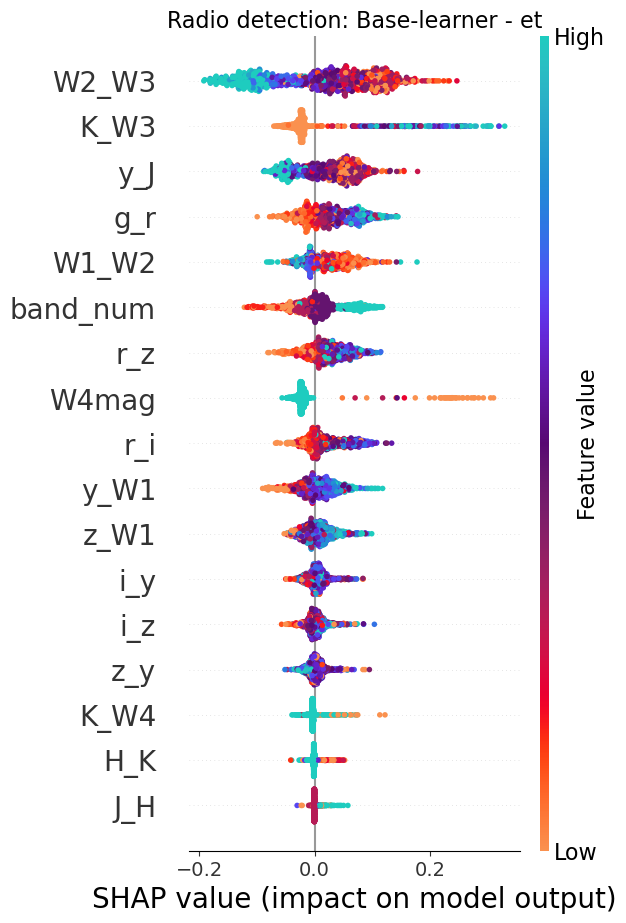

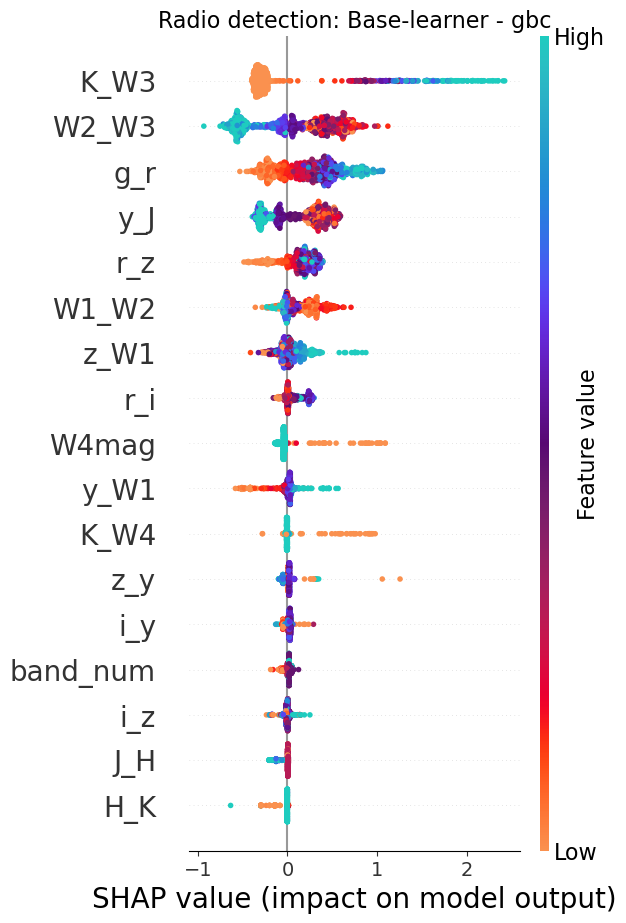

In [46]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        gf.plot_shap_beeswarm('Radio detection', model, shap_values_radio_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_radio_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

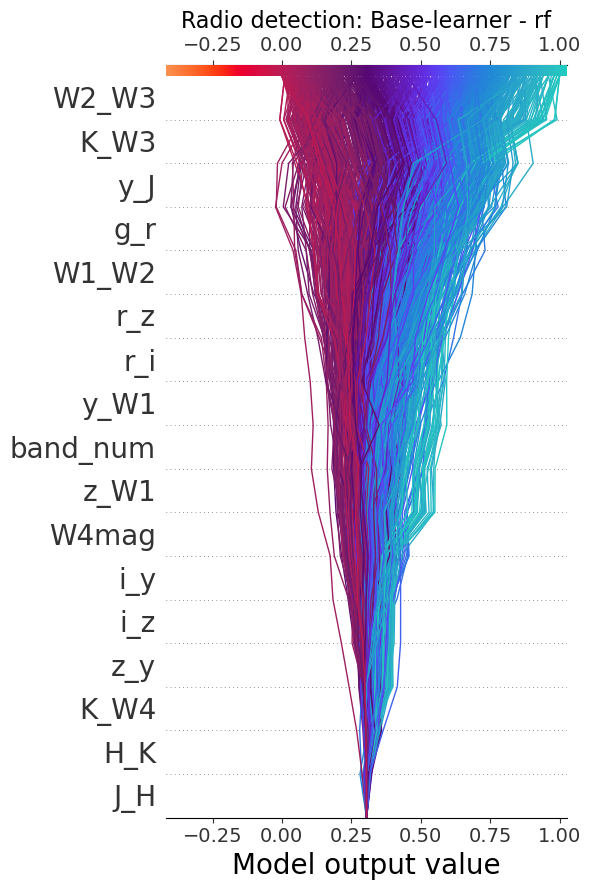

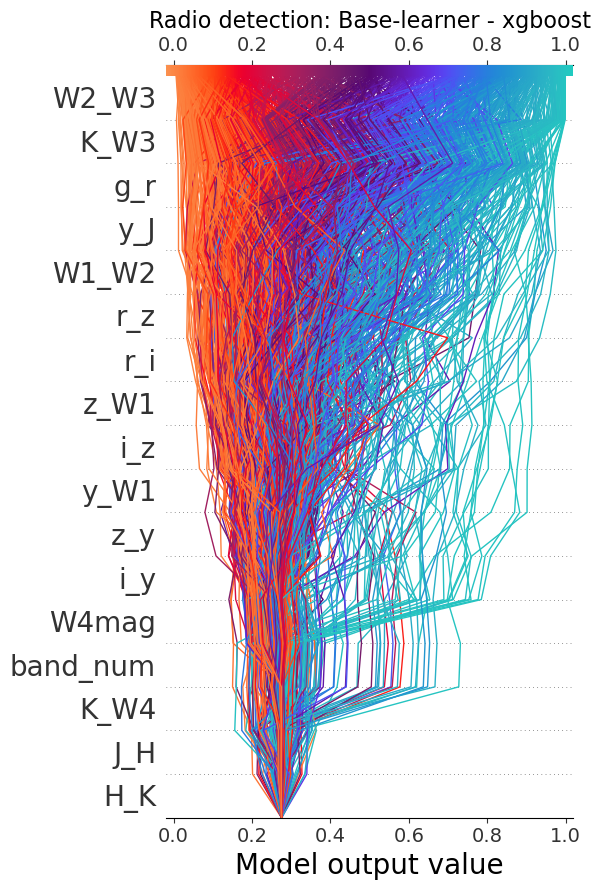

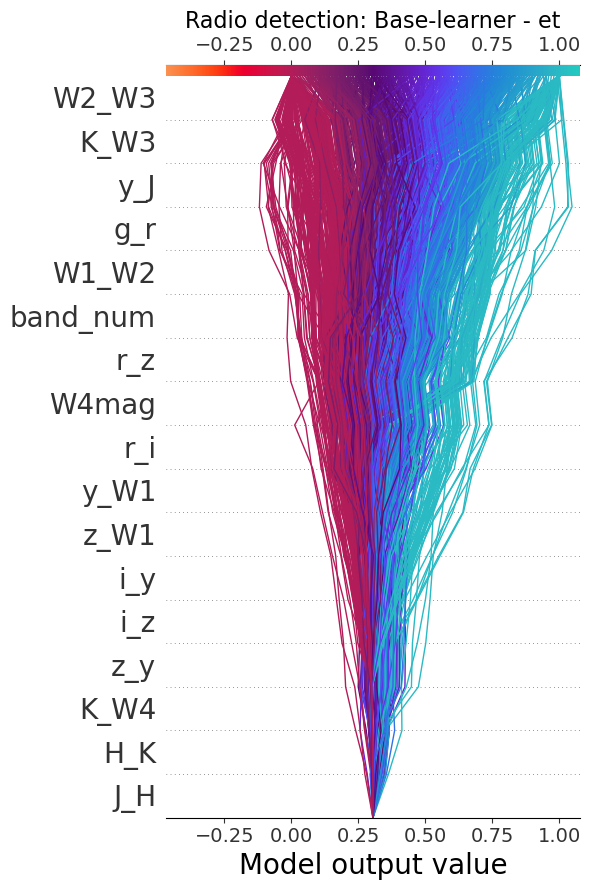

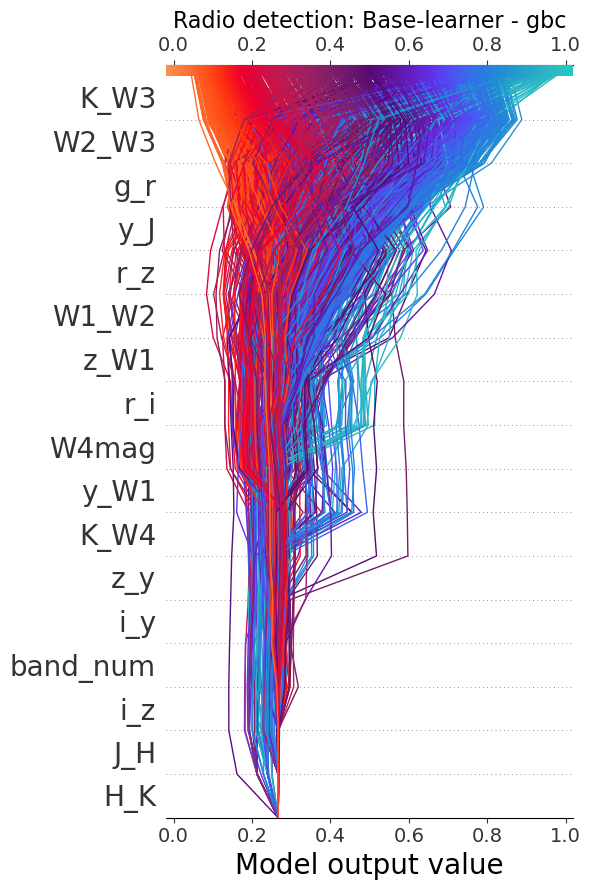

In [47]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        size_side       = 6
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode = 'logit'
        else:
            logit_mode = 'identity'
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Radio detection', model, shap_values_radio_base[model], explainers_radio_base[model],\
                                  reduced_cols_radio, ax1, logit_mode, new_base_value=None, base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_radio_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [48]:
if run_shap_radio_base:
    for count, model in enumerate(shap_values_radio_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(radio_det_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_radio_df.drop(columns=base_models_name_radio))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_radio_base[model].expected_value]).flatten()[-1] + shap_values_radio_base[model].values[0].sum()).round(5))


rf:
1
0.30485

xgboost:
1
1.51391

et:
0
0.3043

gbc:
0
-0.32016


---

#### SHAP - First redshift prediction model

In [49]:
if run_shap_z_base:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [50]:
if run_shap_z_base:
    sample_size_z        = 1000
    if run_high_z_flag:
        filter_pred_rAGN = np.ones_like(full_catalog_df.loc[:, 'pred_radio_AGN']).astype(bool)
    elif not run_high_z_flag:
        filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    sample_size_z        = np.nanmin([sample_size_z, np.sum(filter_selection * filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 1,000


In [51]:
if run_shap_z_base:
    base_models_name_z = gf.get_base_estimators_names(redshift_reg)

In [52]:
if run_shap_z_base:
    reduced_data_z    = full_catalog_df.loc[filter_selection].sample(n=sample_size_z, random_state=gv.seed).copy()
    reduced_data_z_df = gf.preprocess_data(redshift_reg, reduced_data_z, base_models_name_z)
    reduced_cols_z    = reduced_data_z_df.columns.drop(base_models_name_z)

Use FastTreeSHAP package

In [53]:
if run_shap_z_base:
    explainers_z_base           = {}
    for model, model_fit in zip(redshift_reg.named_steps['trained_model'].estimators, redshift_reg.named_steps['trained_model'].estimators_):
        explainers_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                 model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [54]:
if run_shap_z_base:
    shap_values_z_base = {}
    for model in explainers_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_z_base[model] = explainers_z_base[model](reduced_data_z_df.drop(columns=base_models_name_z))

Working with base model et
Working with base model catboost
Working with base model xgboost
Working with base model gbr


In [55]:
if run_shap_z_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
et        	:  1.3170
catboost  	:  1.3168
xgboost   	:  1.3170
gbr       	:  1.3170


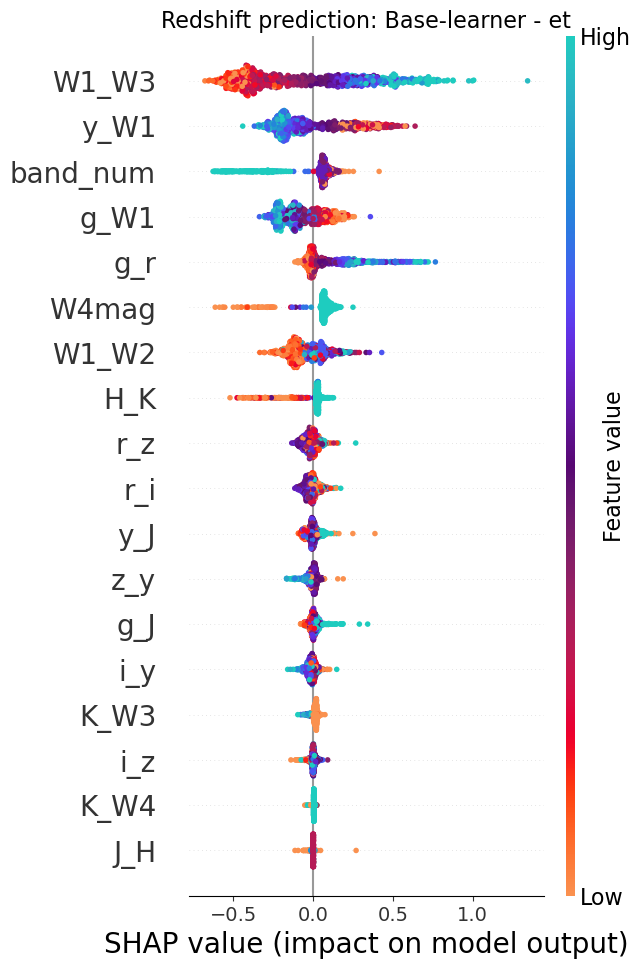

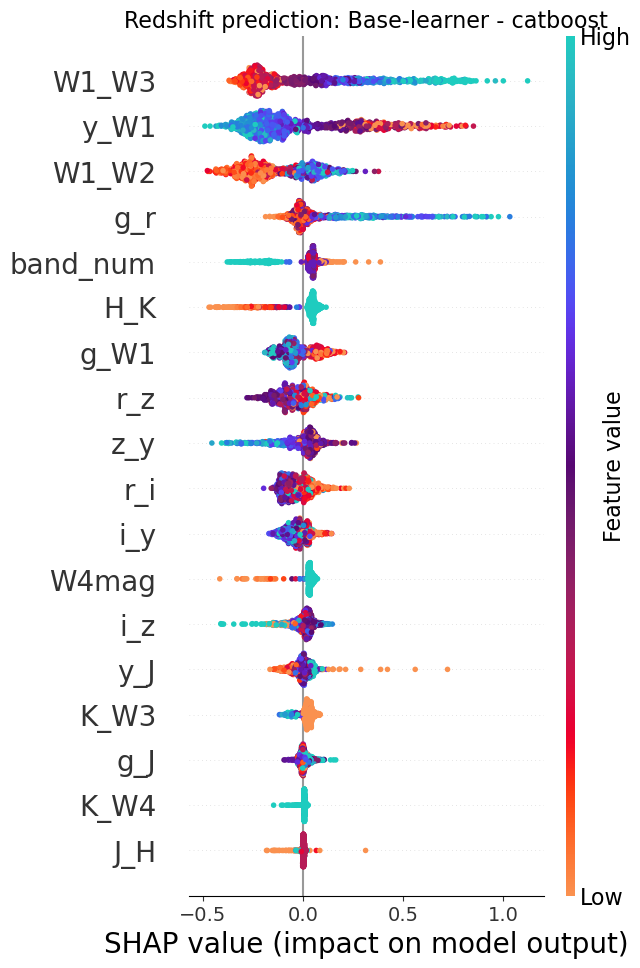

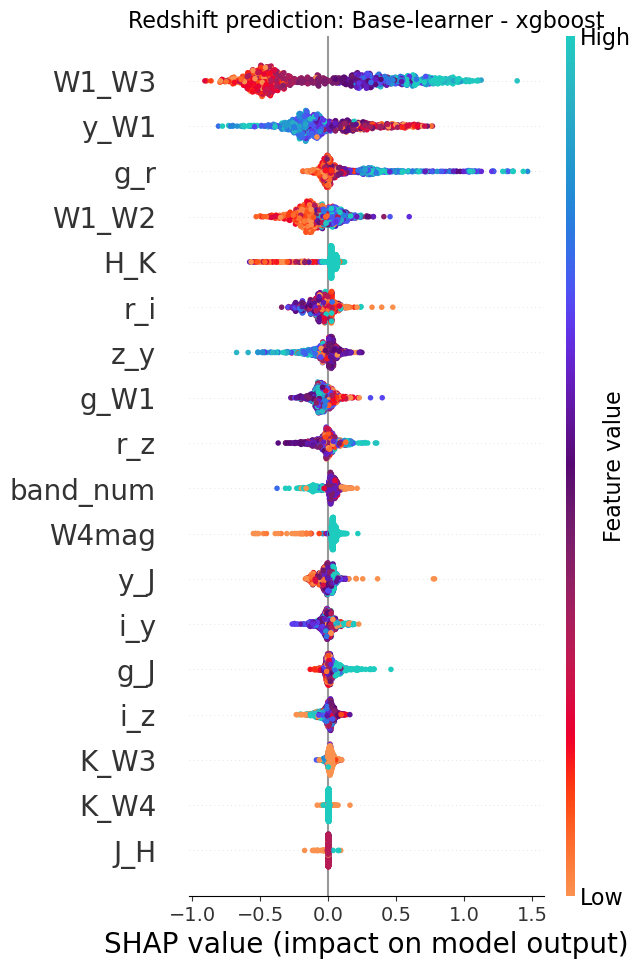

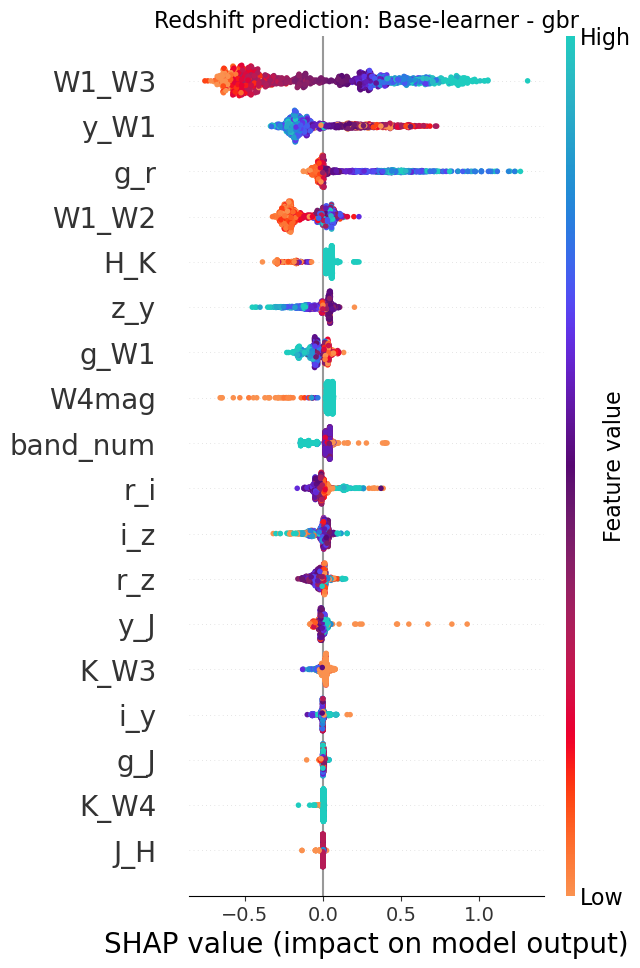

In [56]:
if run_shap_z_base:
    for model in shap_values_z_base.keys():
        gf.plot_shap_beeswarm('Redshift prediction', model, shap_values_z_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

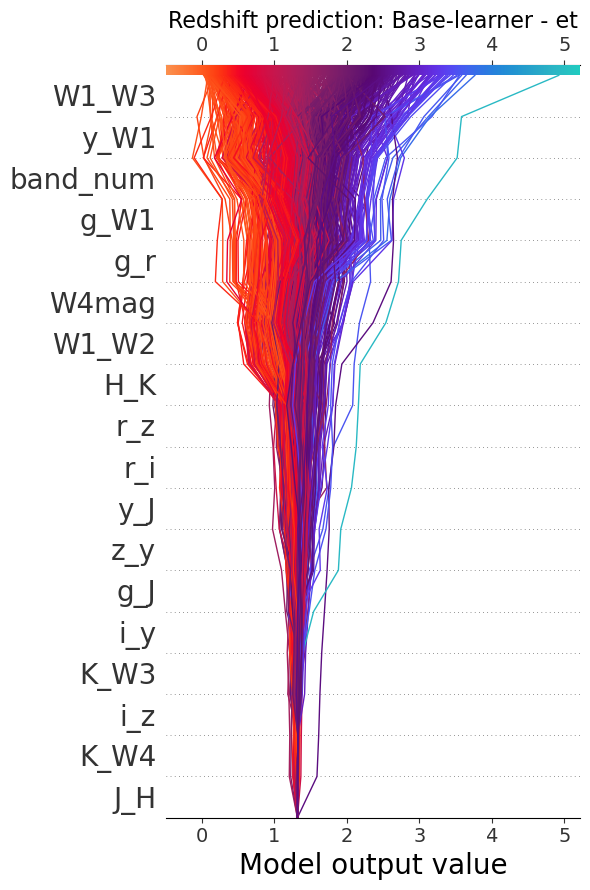

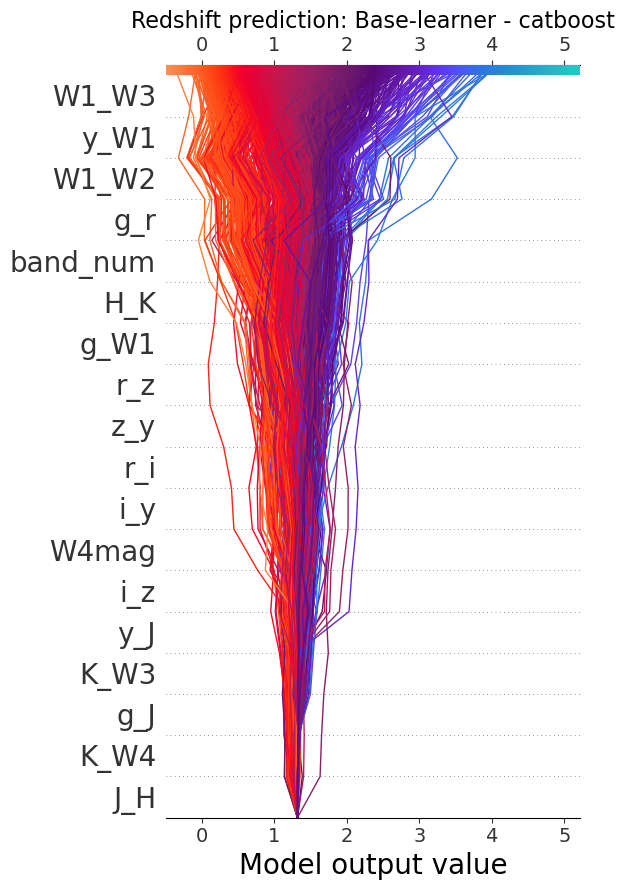

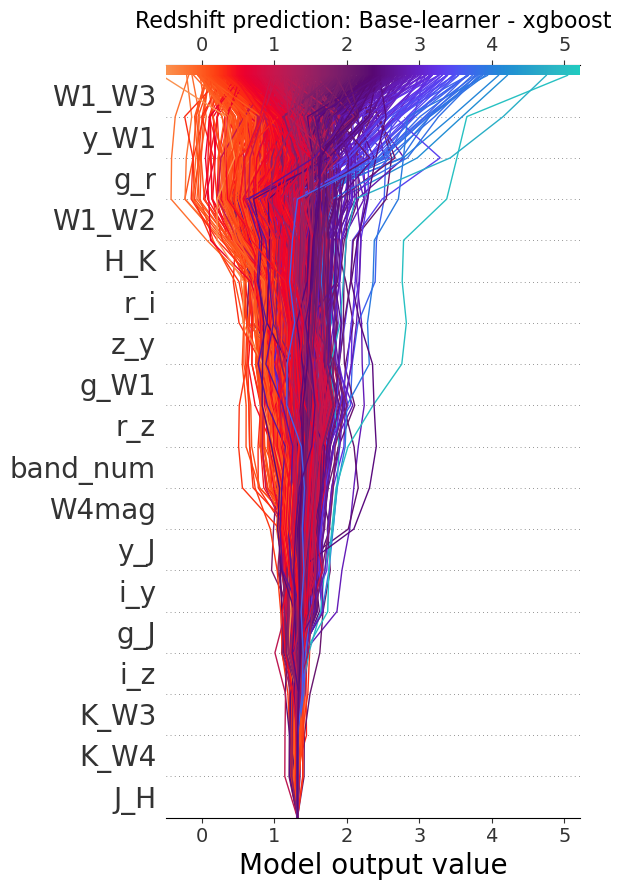

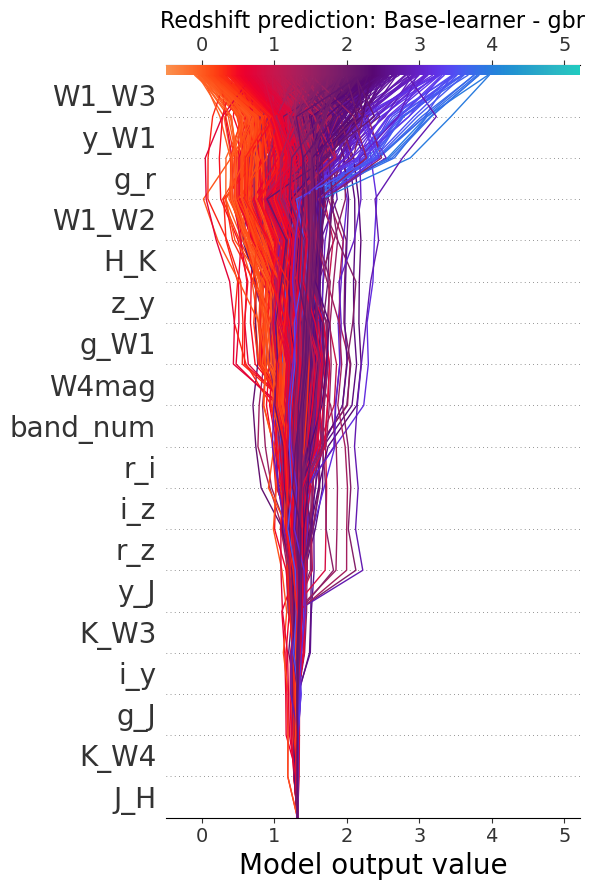

In [71]:
if run_shap_z_base:
    xlims_plt_z         = (-0.5, full_catalog_df.loc[reduced_data_z_df.index, ['Z', 'pred_Z']].max().max() + 0.8)
    for model in shap_values_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Redshift prediction', model, shap_values_z_base[model], explainers_z_base[model],\
                                  reduced_cols_z, ax1, 'identity', new_base_value=None, base_meta='Base', xlim=xlims_plt_z)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [58]:
if run_shap_z_base:
    for count, model in enumerate(shap_values_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg.named_steps['trained_model'].estimators_[count].predict(reduced_data_z_df.drop(columns=base_models_name_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_z_base[model].expected_value[-1] + shap_values_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_z_base[model].expected_value + shap_values_z_base[model].values[0].sum()).round(5))


et:
2.02851
2.02851

catboost:
1.2962
1.2962

xgboost:
2.07108
2.07108

gbr:
1.40608
1.40608


---

#### SHAP - Second redshift prediction model

In [59]:
if not use_second_z_model: run_shap_high_z_meta = False

In [60]:
if run_shap_high_z_base & use_second_z_model:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [61]:
if run_shap_high_z_base & use_second_z_model:
    sample_size_high_z          = 1000
    if run_high_z_flag:
        filter_pred_rAGN_high_z = np.ones_like(full_catalog_df.loc[:, 'pred_Z']).astype(bool)
    elif not run_high_z_flag:
        filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol))
    sample_size_high_z          = np.nanmin([sample_size_high_z, np.sum(filter_selection * filter_pred_rAGN_high_z)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

Number of selected elements: 1,000


In [62]:
if run_shap_high_z_base & use_second_z_model:
    base_models_name_high_z = gf.get_base_estimators_names(redshift_reg_2)

In [63]:
if run_shap_high_z_base & use_second_z_model:
    reduced_data_high_z    = full_catalog_df.loc[filter_selection].sample(n=sample_size_high_z, random_state=gv.seed).copy()
    reduced_data_high_z_df = gf.preprocess_data(redshift_reg_2, reduced_data_high_z, base_models_name_high_z)
    reduced_cols_high_z    = reduced_data_high_z_df.columns.drop(base_models_name_high_z)

Use FastTreeSHAP package

In [64]:
if run_shap_high_z_base & use_second_z_model:
    explainers_high_z_base           = {}
    for model, model_fit in zip(redshift_reg_2.named_steps['trained_model'].estimators, redshift_reg_2.named_steps['trained_model'].estimators_):
        explainers_high_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                      model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [65]:
if run_shap_high_z_base & use_second_z_model:
    shap_values_high_z_base = {}
    for model in explainers_high_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_high_z_base[model] = explainers_high_z_base[model](reduced_data_high_z_df.drop(columns=base_models_name_high_z))

Working with base model catboost
Working with base model gbr
Working with base model et
Working with base model xgboost


In [66]:
if run_shap_high_z_base & use_second_z_model:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_high_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
catboost  	:  2.5567
gbr       	:  2.5567
et        	:  2.5567
xgboost   	:  2.5566


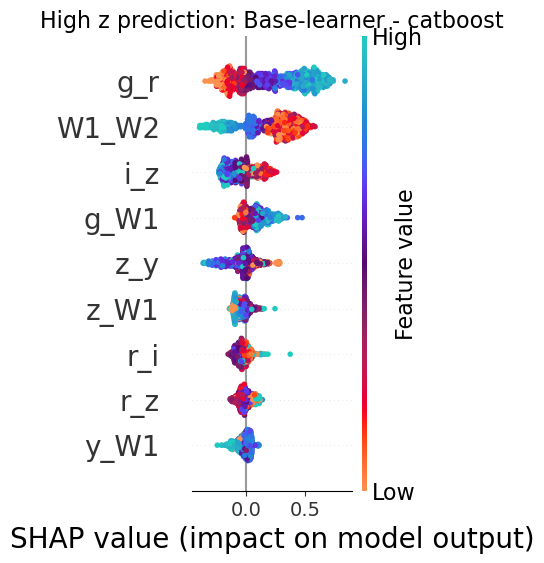

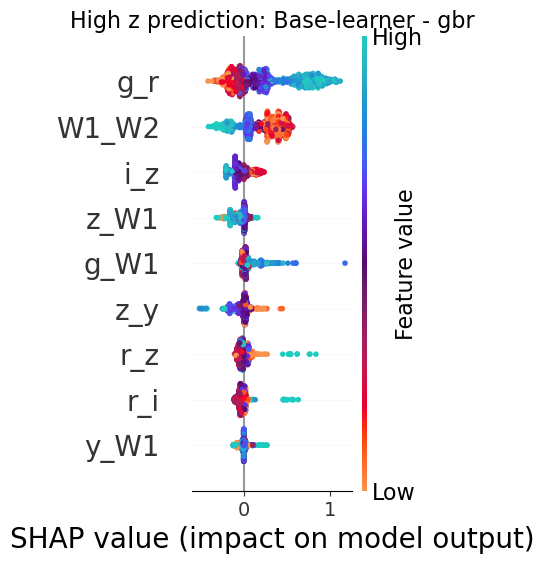

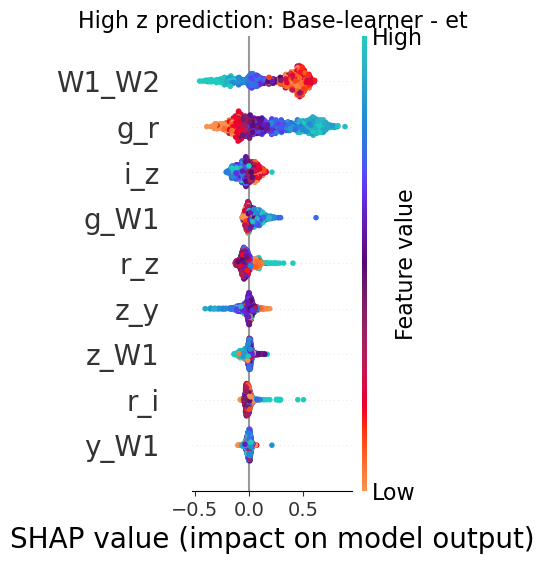

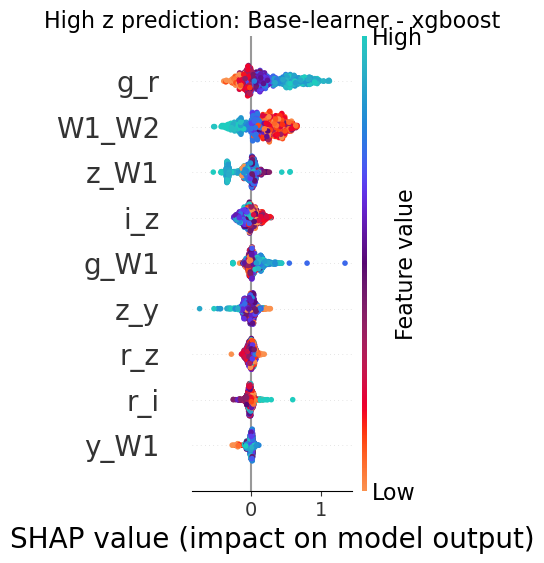

In [67]:
if run_shap_high_z_base & use_second_z_model:
    for model in shap_values_high_z_base.keys():
        gf.plot_shap_beeswarm('High z prediction', model, shap_values_high_z_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_high_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

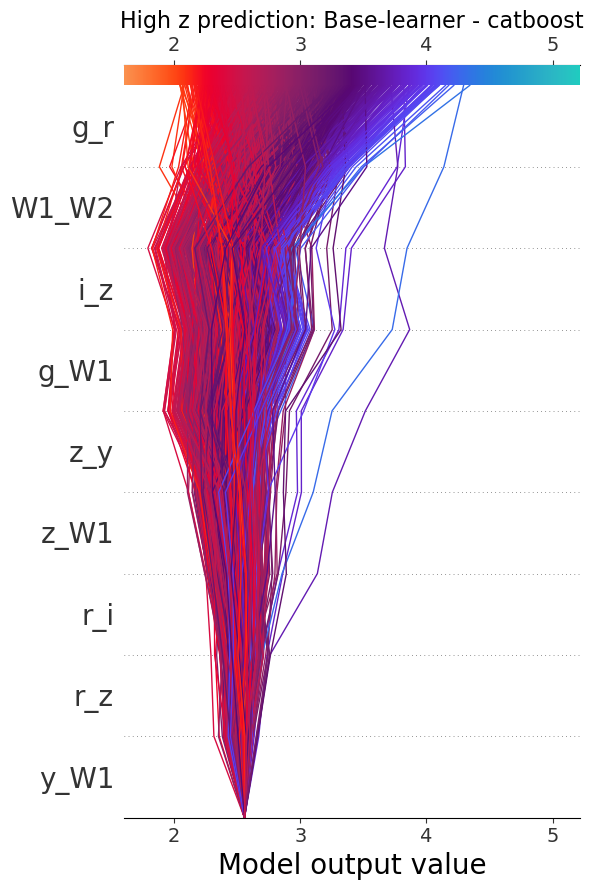

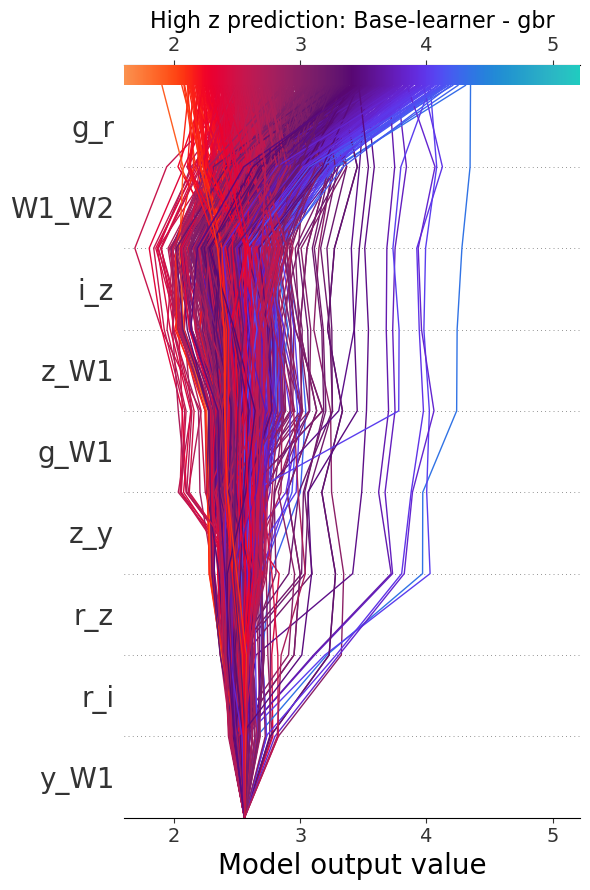

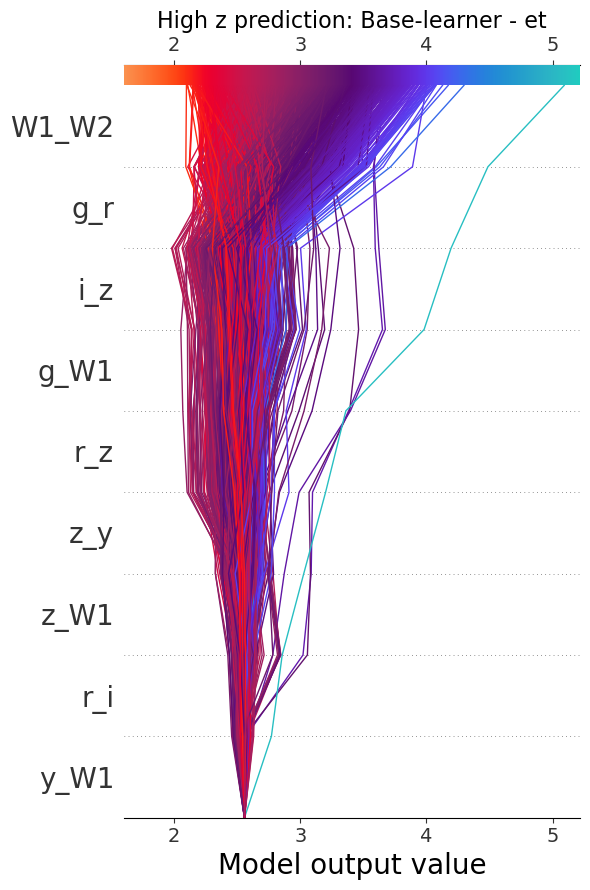

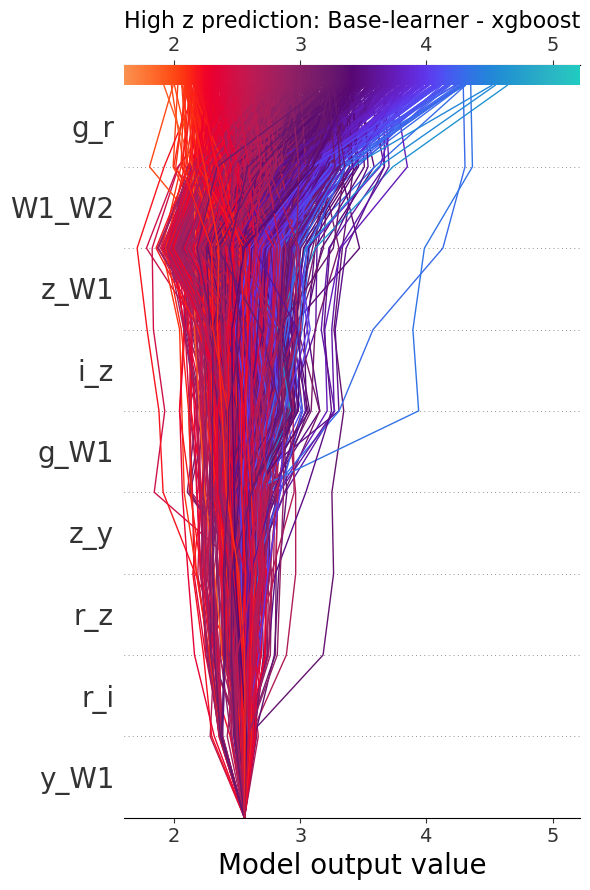

In [72]:
if run_shap_high_z_base & use_second_z_model:
    xlims_plt_hz    = (gv.high_z_limit - 0.4,\
                       full_catalog_df.loc[reduced_data_high_z_df.index, ['Z','pred_Z']].max().max() + 0.8)
    for model in shap_values_high_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('High z prediction', model, shap_values_high_z_base[model],\
                                  explainers_high_z_base[model], reduced_cols_high_z, ax1, 'identity',\
                                  new_base_value=None, base_meta='Base', xlim=xlims_plt_hz)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_high_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [69]:
if run_shap_high_z_base & use_second_z_model:
    for count, model in enumerate(shap_values_high_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg_2.named_steps['trained_model'].estimators_[count].predict(reduced_data_high_z_df.drop(columns=base_models_name_high_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_high_z_base[model].expected_value[-1] + shap_values_high_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_high_z_base[model].expected_value + shap_values_high_z_base[model].values[0].sum()).round(5))


catboost:
2.43057
2.43057

gbr:
2.13425
2.13425

et:
2.59853
2.59853

xgboost:
2.21321
2.21321
